Here we make the quasar error-weighed proper motion velocity field. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord
import pandas as pd
import healpy as hp
from tqdm import *
import emcee
import corner
from uncertainties import ufloat
from uncertainties.umath import *  

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
nside = 16

In [3]:
# Load quasars into a DataFrame
quasars_pd = pd.read_csv("../Lensing-PowerSpectra/Data/quasars_phot.csv")

In [4]:
# Inspect
quasars_pd.columns

Index(['source_id', 'parallax', 'parallax_error', 'ra', 'dec', 'ra_error',
       'dec_error', 'pmra', 'pmdec', 'pmra_error', 'pmdec_error',
       'pmra_pmdec_corr', 'astrometric_gof_al',
       'astrometric_matched_observations', 'visibility_periods_used',
       'astrometric_sigma5d_max', 'radial_velocity', 'radial_velocity_error',
       'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al',
       'astrometric_excess_noise', 'astrometric_excess_noise_sig',
       'astrometric_weight_al', 'astrometric_chi2_al', 'matched_observations',
       'phot_g_mean_mag', 'phot_bp_rp_excess_factor'],
      dtype='object')

In [5]:
# Extract relevant parameters

ra = quasars_pd['ra'].values
dec = quasars_pd['dec'].values

pm_ra_cosdec = quasars_pd['pmra'].values*np.cos(quasars_pd['dec'].values*np.pi/180.)
pm_dec = quasars_pd['pmdec'].values

radial_velocity = quasars_pd['radial_velocity'].values

In [6]:
# Create SkyCoord object (because we live in a society)

quasars_icrs = SkyCoord(ra=ra*u.deg, 
             dec=dec*u.deg, 
             pm_ra_cosdec=pm_ra_cosdec*u.mas/u.yr, 
             pm_dec=pm_dec*u.mas/u.yr,
             radial_velocity=radial_velocity*u.km/u.s,
             frame='icrs')

In [7]:
ra_gal = quasars_icrs.ra.value
dec_gal = quasars_icrs.dec.value

pm_ra_gal = quasars_icrs.pm_ra_cosdec.value
pm_dec_gal = quasars_icrs.pm_dec.value

pm_ra_err = quasars_pd['pmra_error']
pm_dec_err = quasars_pd['pmdec_error']

In [8]:
# Helper function

def idx_to_dec_ra(nside, index):
    """ Return DEC, RA corresponding to HEALPIX pixel ``index`` of given ``nside``
    """
    theta, phi = hp.pixelfunc.pix2ang(nside, index)
    return -np.degrees(theta - np.pi/2.), np.degrees(2*np.pi - phi)

def dec_ra_to_idx(nside, dec,ra):
    """ Return index corresponding to HEALPIX resolution ``nside`` for given 
        angular coordinates ``dec``, ``ra``
    """
    return hp.pixelfunc.ang2pix(nside,np.radians(-dec + 90.), np.radians(360. - ra))

In [9]:
# Initialize array

qpix = dec_ra_to_idx(nside, dec_gal, ra_gal)

quasars_map = np.zeros(hp.nside2npix(nside))

pm_ra_map = np.zeros(hp.nside2npix(nside))
pm_dec_map = np.zeros(hp.nside2npix(nside))

pm_ra_noise_map = np.zeros(hp.nside2npix(nside))
pm_dec_noise_map = np.zeros(hp.nside2npix(nside))

In [10]:
# Fill arrays 

for idx, ipix in enumerate(tqdm_notebook((qpix))):
    quasars_map[ipix] += 1
    pm_ra_map[ipix] += pm_ra_gal[idx]
    pm_dec_map[ipix] += pm_dec_gal[idx]
    
    pm_ra_noise_map[ipix] += pm_ra_err[idx]
    pm_dec_noise_map[ipix] += pm_dec_err[idx]

In [11]:
# Create proper motion maps

pm_v_map = np.zeros(hp.nside2npix(nside))
pm_v_noise_map = np.zeros(hp.nside2npix(nside))

In [12]:
pm_ra_gal_uct = [ufloat(pm_ra_gal[i],pm_ra_err[i]) for i in tqdm_notebook(range(len(qpix)))]
pm_dec_gal_uct = [ufloat(pm_dec_gal[i],pm_dec_err[i]) for i in tqdm_notebook(range(len(qpix)))]

In [13]:
pm_v_gal_uct = [sqrt(pm_ra_gal_uct[i]**2 + pm_dec_gal_uct[i]**2) for i in tqdm_notebook(range(len(qpix)))]

In [14]:
pm_v_gal = [pm_v_gal_uct[i].nominal_value for i in tqdm_notebook(range(len(qpix)))]
pm_v_noise_gal = [pm_v_gal_uct[i].std_dev for i in tqdm_notebook(range(len(qpix)))]

In [15]:
pm_v_map_aux = [[] for i in range(hp.nside2npix(nside))]
pm_v_noise_map_aux = [[] for i in range(hp.nside2npix(nside))]

In [16]:
# Create error-weighed-mean proper motion maps

for idx, ipix in enumerate(tqdm_notebook((qpix))):
    pm_v_map_aux[ipix].append(pm_v_gal[idx])
    pm_v_noise_map_aux[ipix].append(pm_v_noise_gal[idx])

In [17]:
pm_v_map = np.zeros(hp.nside2npix(nside))
pm_v_noise_map = np.zeros(hp.nside2npix(nside))

In [18]:
# Create error-weighed-mean proper motion maps

for ipix in tqdm_notebook(range(hp.nside2npix(nside))):
    v_ary = np.array(pm_v_map_aux[ipix])
    dv_ary = np.array(pm_v_noise_map_aux[ipix])
    sigma2 = 1/np.sum(1/dv_ary**2)
    ewm = sigma2*np.sum(v_ary/dv_ary**2)
    pm_v_map[ipix] = ewm
    pm_v_noise_map[ipix] = np.sqrt(sigma2)

/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


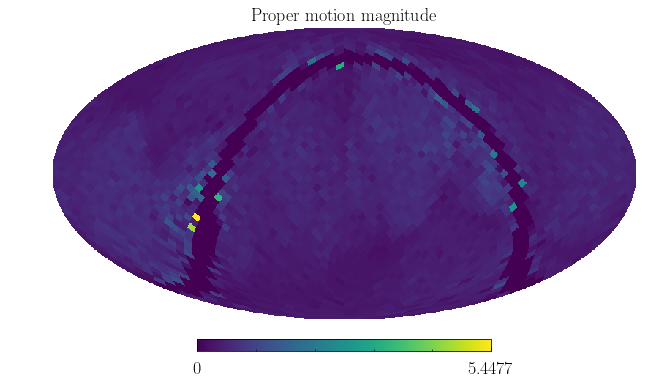

In [19]:
pm_v_map = np.nan_to_num(pm_v_map)
hp.mollview(pm_v_map, title="Proper motion magnitude")

In [20]:
# Set noise to something large in pixels where there are no quasars
pm_v_noise_map[pm_v_noise_map == np.inf] = 1e10

In [21]:
np.save("data/pm_v_map_nside" + str(nside), pm_v_map)
np.save("data/pm_v_noise_map_nside" + str(nside), pm_v_noise_map)